In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

from matplotlib import image

In [2]:
img = image.imread("pneu.jpeg")

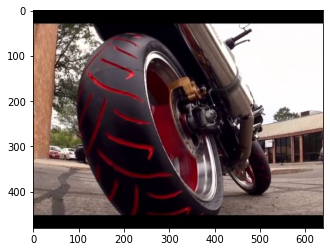

In [4]:
from skimage import data
plt.imshow(img);

👉 What's the image shape? 

In [5]:
img_shape = img.shape
img_shape

(480, 640, 3)

 👉 What do the image elements correspond to ?

In [6]:
img[0]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [11]:
val = []
for k in list(range(img_shape[0])):
    val.append( np.amax( img[k] ) )

In [12]:
min(val), max(val)

(0, 255)

Image colors may contain up to 256**3 = 16M potential colors.

👉 To represent the image correctly for machine learning use, we want to represent every observation sample (pixel) as just a color.

For that, we need to **reshape** the image that currently has a size of `width x height x 3` to a long column vector of size N x 3 where `N = width x height`. 

In [13]:
width = img_shape[0]
height = img_shape[1]

N = width * height 

reshaped_img = img.reshape(N, img_shape[2])
#reshaped_img = reshaped_img.transpose()

reshaped_img.shape  

(307200, 3)

 * **The image size is 307,200 pixels.**
 * Image colors may contain up to 256**3 = 16M potential colors.

In [14]:
data = pd.DataFrame(reshaped_img)
data.head(2)

,0,1,2
0,0,0,0
1,0,0,0


In [15]:
data.tail()

,0,1,2
307195,0,0,0
307196,0,0,0
307197,0,0,0
307198,0,0,0
307199,0,0,0


Image colors may contain up to 256**3 = 16M potential colors. 

Well, actually, it uses less colors because the image size is only 307,200 pixels. 

👉 How many *different* colors are in this picture ?

In [16]:
color_count =  data.drop_duplicates().shape[0]
color_count

52703

There are 52_703 different Colors 

In [17]:
data.apply(lambda row: f'{row[0]},{row[1]},{row[2]}', axis=1)

0         0,0,0
1         0,0,0
2         0,0,0
3         0,0,0
4         0,0,0
          ...  
307195    0,0,0
307196    0,0,0
307197    0,0,0
307198    0,0,0
307199    0,0,0
Length: 307200, dtype: object

In [18]:
# Much longer way!
data['RGB_code'] = data.apply(lambda row: f'{row[0]},{row[1]},{row[2]}', axis=1)
data['RGB_code'].nunique()

52703

# Compress the image by reducing numbers of colors using K-means

- We will reduce these 52703 colors to **K**  max colors, using a KMeans algorithm over the pixels, with the number of clusters being equal to **K**!

- By choosing **K** clusters, the Kmeans is trying to find **K** groups of similar pixels (close in color). 

- The center of each group (or cluster) is going to be the average color of the pixels that belong to it. 

- We can use this "mean color" to replace all the pixels in each cluster by this mean color.

In [19]:
data.shape, reshaped_img.shape, type(data), type(reshaped_img)

((307200, 4), (307200, 3), pandas.core.frame.DataFrame, numpy.ndarray)

👉 First let's try to reduce the image to 32 colors. 

In [20]:
km = KMeans(n_clusters= 32)
km.fit(reshaped_img)

KMeans(n_clusters=32)

We've just created our compression! 

The 32 cluster centers are now our new colors. 

👉 Check the computed `labels_` as well as each `cluster_centers_` of our KMean model.

In [21]:
# Labels
labels = km.labels_
print(labels.shape) # investigating the shape.
pd.DataFrame(labels)

(307200,)


,0
0,17
1,17
2,17
3,17
4,17
...,...
307195,17
307196,17
307197,17
307198,17


In [22]:
pd.DataFrame(labels)[0].nunique()

32

In [23]:
pd.DataFrame(labels)[0].min(), pd.DataFrame(labels)[0].max()

(0, 31)

In [24]:
# Centroids
centers = km.cluster_centers_
print(centers.shape) # investigating the shape.
pd.DataFrame(centers[km.labels_, :])

(32, 3)


,0,1,2
0,0.454869,0.151598,0.77476
1,0.454869,0.151598,0.77476
2,0.454869,0.151598,0.77476
3,0.454869,0.151598,0.77476
4,0.454869,0.151598,0.77476
...,...,...,...
307195,0.454869,0.151598,0.77476
307196,0.454869,0.151598,0.77476
307197,0.454869,0.151598,0.77476
307198,0.454869,0.151598,0.77476


As we can see, we have an assignment of every pixel to the cluster it belongs to. We will use that to find what this color is and plot our compressed image.

👉 Create an `X_compressed` variable of shape (307200 , 3), which contains each pixel and their associated new colors. X is the "flattened" version of a compressed image.

In [25]:
X_compressed = centers[labels, :]
print(X_compressed.shape)
X_compressed

(307200, 3)


array([[0.4548686 , 0.15159835, 0.77475976],
       [0.4548686 , 0.15159835, 0.77475976],
       [0.4548686 , 0.15159835, 0.77475976],
       ...,
       [0.4548686 , 0.15159835, 0.77475976],
       [0.4548686 , 0.15159835, 0.77475976],
       [0.4548686 , 0.15159835, 0.77475976]])

👉 Almost there! 'float64' RGB values needs to be converted to integer between 0 and 255 to have a color that the computer can understand.

In [26]:
X_compressed = X_compressed.astype(np.uint8)
X_compressed

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

Double check that the number of unique colors used is indeed 32

In [27]:
len(np.unique(X_compressed, axis=0)) # , axis=0 is mandatory
#N.B : len(np.unique(X_compressed)) = 77

32

# Plot compressed image , 32 colors

👉 Reshape the compressed image

In [28]:
X_compressed.shape

(307200, 3)

In [29]:
#width = img_shape[0]
#height = img_shape[1]
#N = width * height 

In [30]:
img_compressed = X_compressed.reshape(width, height, img_shape[2])
img_compressed.shape

(480, 640, 3)

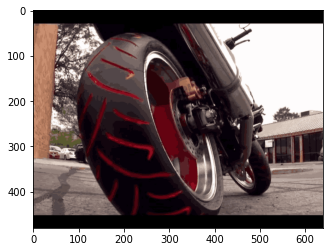

In [31]:
plt.imshow(img_compressed)

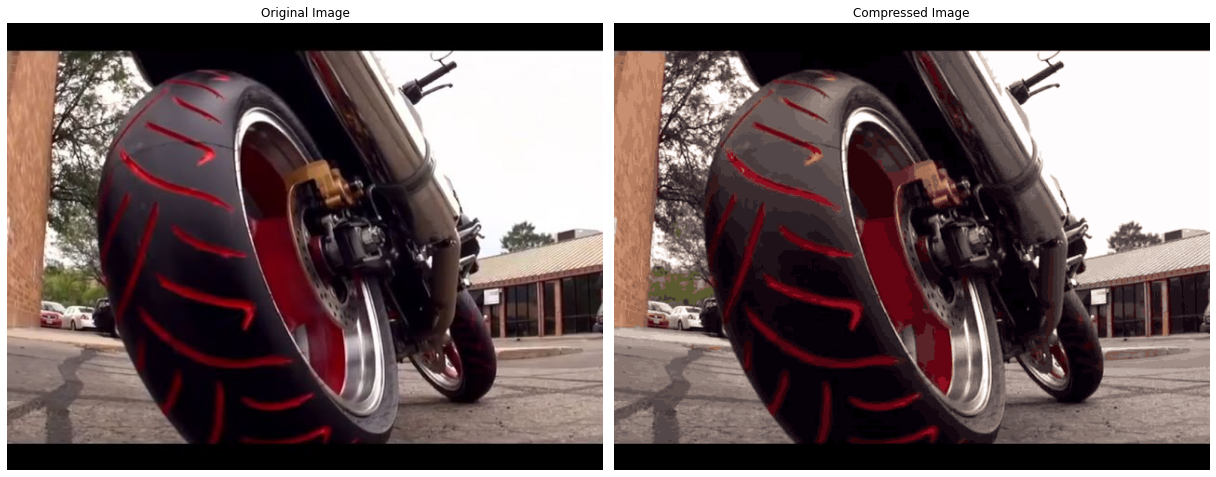

In [32]:
# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 2, figsize = (17, 7))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(img_compressed)
ax[1].set_title('Compressed Image')

for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

# Plot compressed image , 5 or 10 colors

In [33]:
km = KMeans(n_clusters= 10)
km.fit(reshaped_img)

X_compressed_10 = km.cluster_centers_[km.labels_, :]

X_compressed_10 = X_compressed_10.astype(np.uint8)
img_compressed_10 = X_compressed_10.reshape(width, height, img_shape[2])

In [34]:
km = KMeans(n_clusters= 5)
km.fit(reshaped_img)

X_compressed_5 = km.cluster_centers_[km.labels_, :]

X_compressed_5 = X_compressed_5.astype(np.uint8)
img_compressed_5 = X_compressed_5.reshape(width, height, img_shape[2])

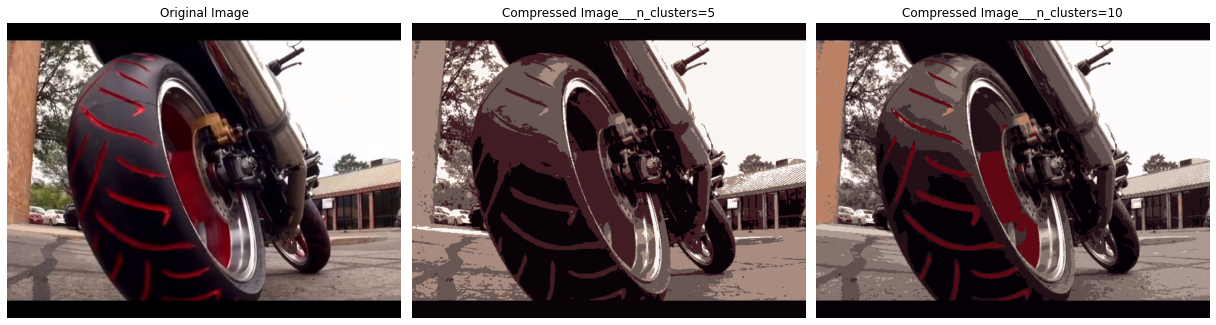

In [35]:
# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 3, figsize = (17, 7))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(img_compressed_5)
ax[1].set_title('Compressed Image___n_clusters=5')
ax[2].imshow(img_compressed_10)
ax[2].set_title('Compressed Image___n_clusters=10')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

# Plot compressed image , 1 or 2 colors

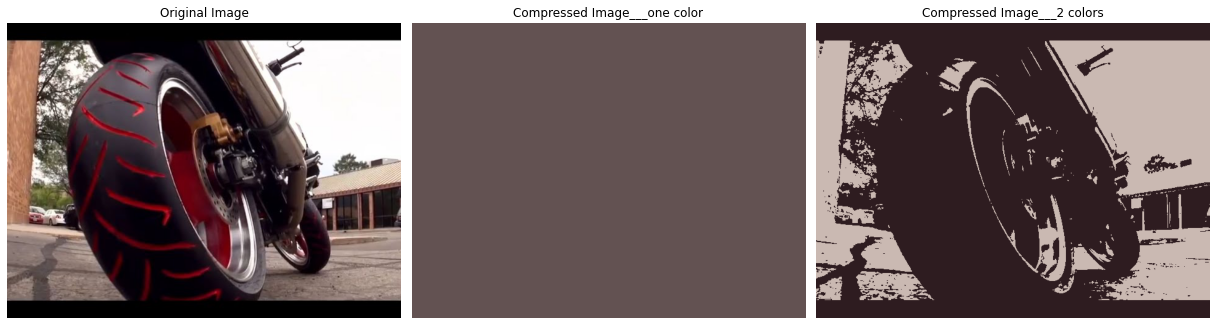

In [36]:
# one color
km = KMeans(n_clusters= 1)
km.fit(reshaped_img)

X_compressed_1 = km.cluster_centers_[km.labels_, :]

X_compressed_1 = X_compressed_1.astype(np.uint8)
img_compressed_1 = X_compressed_1.reshape(width, height, img_shape[2])

# 2 colors
km = KMeans(n_clusters= 2)
km.fit(reshaped_img)

X_compressed_2 = km.cluster_centers_[km.labels_, :]

X_compressed_2 = X_compressed_2.astype(np.uint8)
img_compressed_2 = X_compressed_2.reshape(width, height, img_shape[2])


# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 3, figsize = (17, 7))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(img_compressed_1)
ax[1].set_title('Compressed Image___one color')
ax[2].imshow(img_compressed_2)
ax[2].set_title('Compressed Image___2 colors')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout();